In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.03,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': True
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn, args.feature_norm)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()


            # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
            success_counts = [0 for _ in range(10)]
            failure_counts = [0 for _ in range(10)]

            # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
            success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
            failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

            # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
            accuracies = [0 for _ in range(10)]


            # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
            with torch.no_grad():
                for images, labels in test_dataloader:
                    if args.gpu != -1:
                        images, labels = images.to(args.device), labels.to(args.device)

                    outputs = model(images)
                    softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                    predicted_labels = torch.argmax(softmax_probs, dim=1)

                    for i in range(len(labels)):
                        label = labels[i].item()
                        predicted_label = predicted_labels[i].item()
                        prob_vector = softmax_probs[i]

                        if predicted_label == label:
                            # 예측 성공한 경우
                            success_counts[label] += 1
                            success_prob_sums[label] += prob_vector
                            accuracies[label] += 1
                        else:
                            # 예측 실패한 경우
                            failure_counts[label] += 1
                            failure_prob_sums[label] += prob_vector


        # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
        success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
        failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
        classwise_accuracy=[]

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
            classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
            print("Success Probability Vector:")
            print(success_prob_vectors[i])

        # 결과 출력
        for i in range(10):
            print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")

            print("Failure Probability Vector:")
            print(failure_prob_vectors[i])
        print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 86.90%
Success Probability Vector:
tensor([9.7572e-01, 1.2829e-03, 6.4483e-03, 2.2415e-03, 2.0366e-03, 7.6976e-04,
        6.0811e-04, 1.1242e-03, 6.1704e-03, 3.5978e-03], device='cuda:0')
Class 2 - Accuracy: 91.70%
Success Probability Vector:
tensor([1.2521e-03, 9.8746e-01, 2.0067e-04, 2.5783e-04, 2.2771e-04, 6.9480e-04,
        3.3298e-04, 1.7281e-04, 2.3347e-03, 7.0696e-03], device='cuda:0')
Class 3 - Accuracy: 77.20%
Success Probability Vector:
tensor([6.6344e-03, 3.2783e-04, 9.6255e-01, 8.3329e-03, 7.2752e-03, 5.5542e-03,
        5.5412e-03, 1.1022e-03, 1.8272e-03, 8.5736e-04], device='cuda:0')
Class 4 - Accuracy: 67.10%
Success Probability Vector:
tensor([3.7734e-03, 9.8139e-04, 8.7244e-03, 9.3892e-01, 8.0703e-03, 2.2848e-02,
        7.6891e-03, 5.0940e-03, 2.9985e-03, 9.0054e-04], device='cuda:0')
Class 5 - Accuracy: 82.60%
Success Probability Vector:
tensor([1.6110e-03, 2.4952e-04, 9

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.3998018840721284e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.3117712321716467e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.380748936714827e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 1.3864247986152597e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Successful): Mean = 1.0, Variance = 1.3639471911730907e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.2677083664972412e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.6013724321126024e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.5380650837556976e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.4899865407

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.03,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': True
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn, args.feature_norm)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            print(before_acc_results)

            print ("Before min/max/mean/std of accuracy")
            print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))

                    
                    


Files already downloaded and verified
Files already downloaded and verified
[86.0, 83.0, 92.0, 85.0, 82.0, 83.0, 84.0, 85.0, 82.0, 85.0, 85.0, 82.0, 85.0, 83.0, 86.0, 79.0, 86.0, 88.0, 82.0, 79.0, 79.0, 77.0, 80.0, 83.0, 87.0, 84.0, 85.0, 82.0, 86.0, 83.0, 82.0, 84.0, 86.0, 86.0, 87.0, 85.0, 81.0, 83.0, 83.0, 85.0, 86.0, 84.0, 87.0, 88.0, 82.0, 80.0, 83.0, 86.0, 87.0, 84.0, 81.0, 87.0, 81.0, 83.0, 82.0, 83.0, 78.0, 81.0, 86.0, 83.0, 83.0, 89.0, 81.0, 84.0, 82.0, 77.0, 87.0, 78.0, 86.0, 78.0, 82.0, 87.0, 83.0, 89.0, 85.0, 81.0, 86.0, 84.0, 82.0, 90.0, 89.0, 82.0, 88.0, 84.0, 89.0, 76.0, 88.0, 78.0, 87.0, 80.0, 87.0, 88.0, 88.0, 80.0, 79.0, 77.0, 85.0, 84.0, 83.0, 93.0]
Before min/max/mean/std of accuracy
76.0 93.0 83.81 3.38


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 49, 1: 54, 2: 56, 3: 40, 4: 54, 5: 47, 6: 54, 7: 53, 8: 47, 9: 46}, 1: {0: 46, 1: 52, 2: 45, 3: 42, 4: 59, 5: 45, 6: 53, 7: 64, 8: 41, 9: 53}, 2: {0: 47, 1: 52, 2: 56, 3: 41, 4: 53, 5: 43, 6: 38, 7: 52, 8: 55, 9: 63}, 3: {0: 49, 1: 44, 2: 53, 3: 52, 4: 56, 5: 56, 6: 45, 7: 47, 8: 55, 9: 43}, 4: {0: 50, 1: 54, 2: 49, 3: 54, 4: 45, 5: 53, 6: 55, 7: 47, 8: 53, 9: 40}, 5: {0: 47, 1: 44, 2: 38, 3: 52, 4: 54, 5: 63, 6: 54, 7: 53, 8: 49, 9: 46}, 6: {0: 41, 1: 53, 2: 54, 3: 47, 4: 55, 5: 44, 6: 53, 7: 58, 8: 51, 9: 44}, 7: {0: 58, 1: 44, 2: 49, 3: 42, 4: 63, 5: 45, 6: 60, 7: 43, 8: 55, 9: 41}, 8: {0: 40, 1: 44, 2: 60, 3: 48, 4: 49, 5: 37, 6: 60, 7: 52, 8: 63, 9: 47}, 9: {0: 53, 1: 45, 2: 49, 3: 65, 4: 58, 5: 42, 6: 55, 7: 43, 8: 38, 9: 52}, 10: {0: 54, 1: 54, 2: 46, 3: 42, 4: 41, 5: 53, 6: 54, 7: 54, 8: 50, 9: 52}, 11: {0: 46, 1: 51, 2: 50, 3: 47, 4: 48, 5: 55, 6: 55, 7: 43, 8: 58, 9: 47}, 12: {0: 58, 1: 49, 2: 45, 3: 54, 4: 59, 5:

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 4, 1: 12, 2: 18, 3: 10, 4: 7, 5: 11, 6: 13, 7: 7, 8: 12, 9: 6}, 1: {0: 7, 1: 12, 2: 12, 3: 6, 4: 8, 5: 11, 6: 8, 7: 16, 8: 12, 9: 8}, 2: {0: 10, 1: 11, 2: 8, 3: 13, 4: 6, 5: 10, 6: 12, 7: 8, 8: 9, 9: 13}, 3: {0: 12, 1: 12, 2: 9, 3: 5, 4: 8, 5: 13, 6: 12, 7: 7, 8: 8, 9: 14}, 4: {0: 6, 1: 10, 2: 7, 3: 8, 4: 10, 5: 12, 6: 9, 7: 15, 8: 11, 9: 12}, 5: {0: 9, 1: 13, 2: 9, 3: 9, 4: 14, 5: 8, 6: 18, 7: 6, 8: 7, 9: 7}, 6: {0: 11, 1: 12, 2: 11, 3: 8, 4: 6, 5: 10, 6: 10, 7: 9, 8: 9, 9: 14}, 7: {0: 11, 1: 11, 2: 6, 3: 13, 4: 9, 5: 12, 6: 8, 7: 8, 8: 11, 9: 11}, 8: {0: 12, 1: 9, 2: 10, 3: 7, 4: 16, 5: 13, 6: 8, 7: 7, 8: 8, 9: 10}, 9: {0: 15, 1: 7, 2: 10, 3: 10, 4: 18, 5: 10, 6: 6, 7: 3, 8: 11, 9: 10}, 10: {0: 10, 1: 12, 2: 8, 3: 11, 4: 9, 5: 9, 6: 8, 7: 14, 8: 9, 9: 10}, 11: {0: 11, 1: 11, 2: 13, 3: 11, 4: 6, 5: 12, 6: 10, 7: 13, 8: 9, 9: 4}, 12: {0: 6, 1: 10, 2: 11, 3: 12, 4: 8, 5: 10, 6: 9, 7: 12, 8: 12, 9: 10}, 13: {0: 20, 1: 7, 2: 11

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.0373, -0.0103,  0.0049,  0.0279, -0.0498,  0.0468,  0.0259, -0.0791,
        -0.0217,  0.0374], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([68.5840, 73.3409, 66.5962, 64.3093, 71.0109, 69.0910, 72.0484, 71.1605,
        73.6628, 70.6153], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0592, -0.0216, -0.2173, -0.1633, -0.2300, -0.2519, -0.1583,
          0.1368, -0.0424],
        [-0.0592,  1.0000, -0.2426, -0.1819, -0.2516, -0.2003, -0.1251, -0.1966,
          0.0479,  0.1682],
        [-0.0216, -0.2426,  1.0000, -0.0610,  0.0356, -0.0503, -0.0252, -0.1897,
         -0.1452, -0.2467],
        [-0.2173, -0.1819, -0.0610,  1.0000, -0.1539,  0.1401,  0.0243, -0.1111,
         -0.1885, -0.1982],
        [-0.1633, -0.2516,  0.0356, -0.1539,  1.0000, -0.0735,  0.0438,  0.0517,
         -0.2130, -0.2

Weight norm of each class part of classifier
tensor([8.2815, 8.5639, 8.1607, 8.0193, 8.4268, 8.3121, 8.4881, 8.4357, 8.5827,
        8.4033], device='cuda:0', grad_fn=<SqrtBackward0>)


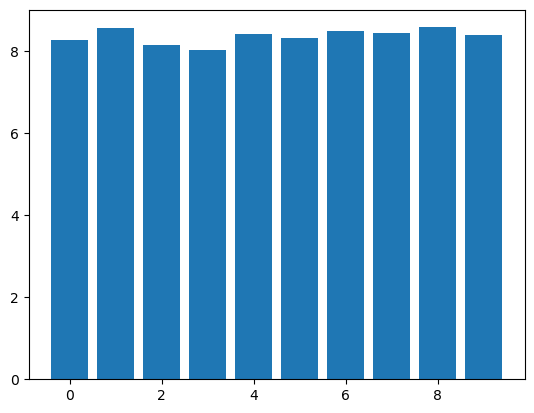

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

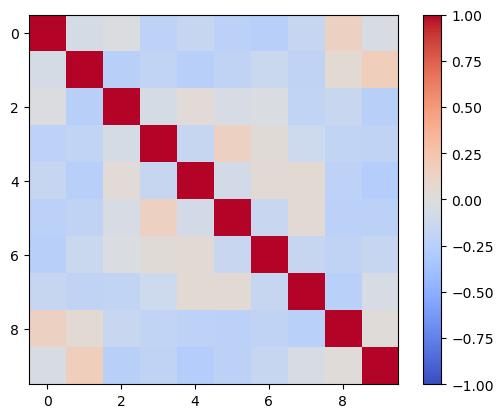

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.8934188, 1: 0.93929005, 2: 0.8330144, 3: 0.77734435, 4: 0.8720736, 5: 0.8346421, 6: 0.89707935, 7: 0.8990894, 8: 0.9292272, 9: 0.92171425}
-------------------VAR-------------------
{0: 0.044253405, 1: 0.027508311, 2: 0.057762742, 3: 0.054998085, 4: 0.04253442, 5: 0.053736117, 6: 0.040459678, 7: 0.042885896, 8: 0.033924278, 9: 0.035535827}


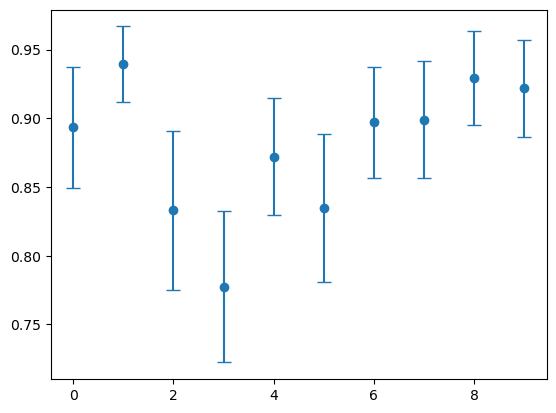

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.03,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': True
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn, args.feature_norm)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

            dict_save_path = 'dict_users_10.pkl'
            with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                dict_users_train, dict_users_test = pickle.load(handle)


            # build model
            net_glob = get_model(args)
            net_glob.train()


            net_local_list = []
            for user_ix in range(args.num_users):
                net_local_list.append(copy.deepcopy(net_glob))

            criterion = nn.CrossEntropyLoss()

            before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
            after_acc_results = []

            for user, net_local in enumerate(net_local_list):
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                before_acc_results.append(acc_test)

            net_local_list[0].eval()

            label= [i for i in range(num_classes)]                    


            ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
            class_sums = {i: None for i in label}
            class_counts = {i: None for i in label}



            with torch.no_grad():
                for idx, (images, labels) in enumerate(ldr_test):
                    images, labels = images.to(args.device), labels.to(args.device)
                    features = net_local_list[0].extract_features(images)

                    for i in range(len(label)):
                        class_mask = labels == label[i]  

                        if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                            class_features = features[class_mask]
                            class_sum = class_features.sum(dim=0)
                            count=class_features.shape[0]

                            if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                class_sums[label[i]]=class_sum
                                class_counts[label[i]]=count
                            else:
                                class_sums[label[i]]+=class_sum
                                class_counts[label[i]]+=count

            #Get the class-wise feature centroid                    
            class_mean_dict={}
            for key, value in class_sums.items():
                if key in class_counts:
                    class_mean_dict[key] = value / class_counts[key]

            print(class_mean_dict)
            #Get a Inner product of each class's centroid vector

            sorted_keys=sorted(class_mean_dict)
            print(sorted_keys)

            class_mean_lst=[]


            for key in sorted_keys:
                class_mean_lst.append(class_mean_dict[key])

            class_mean_lst=torch.stack(class_mean_lst)


            print(class_mean_lst.shape)
            print(class_mean_lst.transpose(0,1).shape)

            #Get the each centroid vector's norm
            print("-------------Norm of each centroid vectors --------------")
            print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


            #Get the cosine similarity result between eacn centroid vectors


            normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
            print("-------------Cosine similarity of Each Centroid vectors--------------")
            print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())





Files already downloaded and verified
Files already downloaded and verified
{0: tensor([7.0445e-02, 6.1050e-03, 5.8363e-02, 3.0586e-03, 2.7611e-03, 5.5853e-04,
        3.7753e-03, 8.0269e-03, 7.8623e-02, 3.7708e-06, 9.5882e-04, 3.0694e-03,
        1.1699e-02, 5.1641e-03, 1.6350e-03, 7.3163e-03, 2.1520e-01, 1.1238e-02,
        2.0010e-03, 1.7773e-03, 3.0917e-03, 1.8061e-03, 5.8166e-03, 6.2732e-03,
        1.1259e-02, 2.1427e-03, 1.2549e-02, 5.2226e-02, 6.4145e-03, 7.6429e-05,
        3.4445e-03, 6.1914e-04, 1.3598e-02, 1.3273e-03, 3.7648e-03, 5.1983e-05,
        1.7847e-03, 1.2151e-04, 3.5824e-05, 1.4203e-02, 1.4632e-01, 0.0000e+00,
        3.0340e-04, 3.1463e-03, 1.0081e-02, 1.8192e-03, 2.3366e-03, 1.8224e-02,
        2.6517e-03, 5.2697e-03, 4.2770e-04, 4.1198e-03, 6.5736e-03, 1.6400e-02,
        3.8464e-02, 8.3696e-04, 3.0692e-02, 9.4493e-03, 3.4679e-02, 5.1603e-05,
        1.9673e-02, 5.7736e-03, 0.0000e+00, 1.2140e-03, 7.6912e-03, 1.7104e-03,
        2.1962e-03, 2.9315e-03, 2.7540e-

# Cosine Similarity of Centroid Vectors

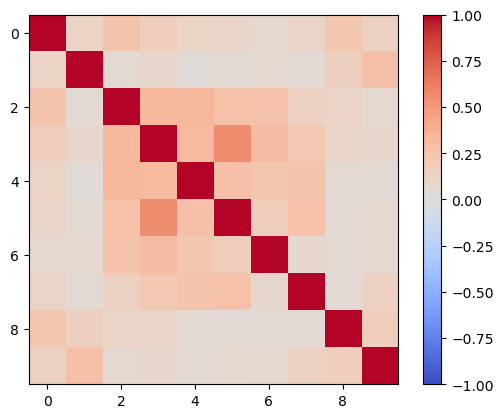

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.99999994 0.12427195 0.2533788  0.15645799 0.12132613 0.10260727
  0.07046539 0.10298178 0.23342945 0.13810751]
 [0.12427195 1.         0.0472262  0.08758475 0.02974382 0.05030622
  0.05814385 0.04499779 0.15384823 0.2753997 ]
 [0.2533788  0.0472262  0.9999999  0.32508412 0.3330619  0.26668736
  0.26081806 0.13885286 0.11271159 0.07020862]
 [0.15645799 0.08758475 0.32508412 1.0000001  0.3172862  0.5614352
  0.30181837 0.21689598 0.10177048 0.08953587]
 [0.12132613 0.02974382 0.3330619  0.3172862  1.         0.27545053
  0.23184131 0.25641862 0.05460992 0.04221272]
 [0.10260727 0.05030622 0.26668736 0.5614352  0.27545053 1.
  0.17268623 0.2673383  0.04641408 0.06299515]
 [0.07046539 0.05814385 0.26081806 0.30181837 0.23184131 0.17268623
  1.         0.08332544 0.04707158 0.05813158]
 [0.10298178 0.04499779 0.13885286 0.21689598 0.25641862 0.2673383
  0.08332544 0.9999999  0.03914594 0.13861047]
 [0.23342945 0.15384823 0.11271159 0.10177048 0.05460992 0.0464140

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.8563, 0.8684, 0.8342, 0.7914, 0.8378, 0.8236, 0.8396, 0.8622, 0.8646,
        0.8703], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.8563, 0.8684, 0.8342, 0.7914, 0.8378, 0.8236, 0.8396, 0.8622, 0.8646,
        0.8703], device='cuda:0', grad_fn=<DiagonalBackward0>)


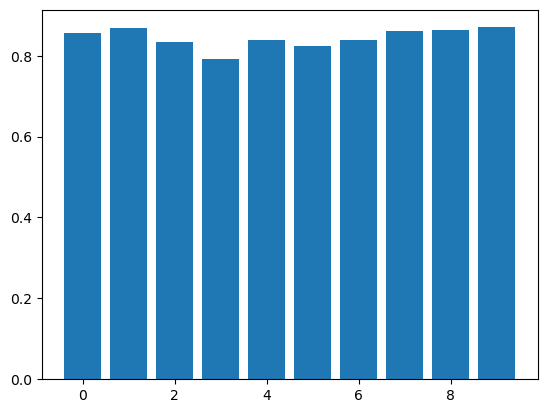

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Singular Value Analysis

Files already downloaded and verified
Files already downloaded and verified
['2.631', '2.272', '2.227', '2.175', '2.147', '2.077', '2.022', '1.957', '1.918', '1.855', '1.055', '1.049', '1.032', '1.027', '1.024', '1.014', '1.007', '1.002', '0.999', '0.996', '0.991', '0.988', '0.980', '0.977', '0.973', '0.970', '0.969', '0.964', '0.957', '0.954', '0.949', '0.948', '0.942', '0.939', '0.934', '0.931', '0.927', '0.926', '0.918', '0.917', '0.912', '0.910', '0.904', '0.902', '0.900', '0.896', '0.891', '0.887', '0.885', '0.883', '0.881', '0.878', '0.875', '0.873', '0.870', '0.865', '0.863', '0.857', '0.856', '0.854', '0.851', '0.848', '0.844', '0.843', '0.840', '0.837', '0.833', '0.831', '0.829', '0.827', '0.825', '0.820', '0.818', '0.815', '0.813', '0.810', '0.804', '0.803', '0.803', '0.799', '0.798', '0.798', '0.793', '0.790', '0.788', '0.786', '0.781', '0.780', '0.778', '0.776', '0.773', '0.771', '0.768', '0.765', '0.763', '0.762', '0.759', '0.757', '0.756', '0.755', '0.751', '0.747', '0.74

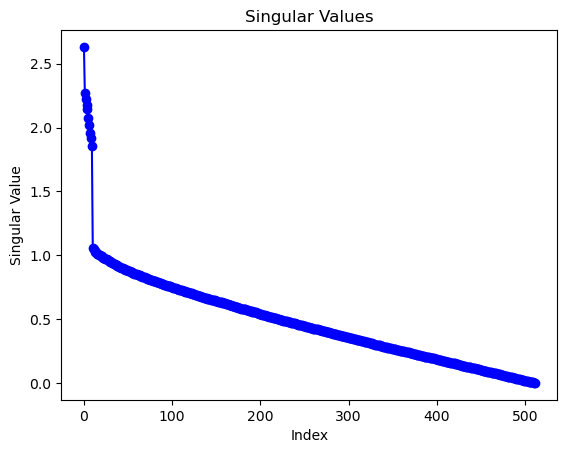

In [18]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for frac in [0.1]:
    for local_ep in [15]:
        for local_upt_part, aggr_part in [('full', 'full')]:
            args = easydict.EasyDict({'epochs': local_ep,
                                      'num_users': 100,
                                      'server_data_ratio': server_data_ratio,
                                      'frac': frac,
                                      'local_ep': local_ep,
                                      'local_bs': 500,
                                      'bs': 50,
                                      'lr': 0.03,
                                      'momentum': momentum,
                                      'wd': wd,
                                      'model': model,


                                      'dataset': dataset,
                                      'iid': True,
                                      'num_classes': num_classes,
                                      'gpu': 0,
                                      'verbose': False,
                                      'seed': 1,
                                      'test_freq': 1,
                                      'load_fed': '',
                                      'results_save': 'run1',
                                      'local_upt_part': local_upt_part,
                                      'aggr_part': aggr_part,
                                      'feature_norm': 1,
                                      'fn': True
                                      })

            # parse args
            args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
            base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd, args.fn, args.feature_norm)
            algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
            dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
            test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


            # build model
            model = get_model(args)
            model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
            model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

            model.eval()

            info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

            # Compute the singular value decomposition (SVD)
            _, s, _ = torch.svd(info_param[0])

            # Sort the singular values in descending order and store them in a list
            sorted_s = sorted(s.tolist(), reverse=True)

            print(["{:.3f}".format(num) for num in sorted_s])

            # Create a list of indices for the singular values
            indices = list(range(len(sorted_s)))

            # Plot the singular values with their indices
            plt.plot(indices, sorted_s, marker='o', linestyle='-', color='b')
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Singular Values')

            # Set x-axis ticks to display only integer values
#                 plt.xticks(indices)

            plt.show()

